LLM Final Assesment

**Employee Sentiment Analysis**

In [277]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,mean_squared_error,r2_score
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from datetime import timedelta


In [ ]:
# Load Dataset
df = pd.read_excel('test.xlsx')

In [ ]:
df['from'].value_counts() # 10 Senders

In [ ]:
df.describe(include='all')

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,NaN,10
top,(No Subject),\n\n,NaN,lydia.delgado@enron.com
freq,141,21,NaN,284
mean,NaN,NaN,2010-12-31 02:17:21.716111360,NaN
min,NaN,NaN,2010-01-01 00:00:00,NaN
25%,NaN,NaN,2010-06-30 12:00:00,NaN
50%,NaN,NaN,2011-01-01 00:00:00,NaN
75%,NaN,NaN,2011-06-30 12:00:00,NaN
max,NaN,NaN,2011-12-31 00:00:00,NaN


In [ ]:
df.head(5)

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


Data Cleaning

In [ ]:
df_filtered = df[df['body'].str.strip() != ''].copy() # Filter where 'body' just contains whitespace


In [ ]:
# remove whitespaces and lowercase the data
df_filtered['body'] = df_filtered['body'].str.lower().str.strip()
df_filtered['Subject'] = df_filtered['Subject'].str.lower().str.strip()
df_filtered['from'] = df_filtered['from'].str.lower().str.strip()

**Sentiment Labeling**

In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained( "cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained( "cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**tokens)
    prob = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(prob).item()

    if predicted == 0:
        return 'negative'
    elif predicted == 1:
        return 'neutral'
    else:
        return 'positive'

In [ ]:
# apply function to dataframe
df_filtered['Sentiments']=df_filtered['body'].apply(predict_sentiment)

**EDA**

In [320]:
df_filtered=pd.read_csv('Sentiment.csv')

In [321]:
 # Convert date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

In [322]:
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

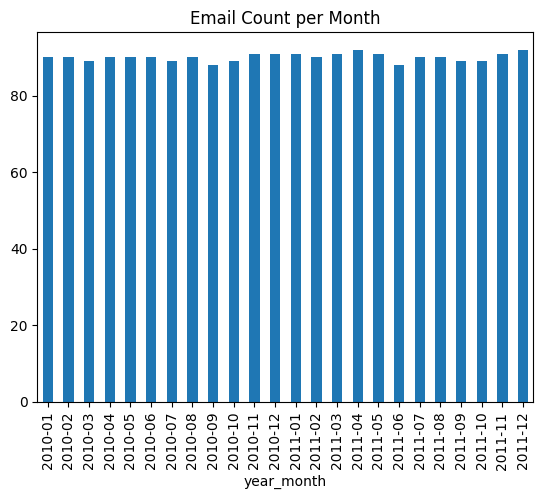

In [323]:
# Email Count per Month Plot
df_filtered['year_month'].value_counts().sort_index().plot(kind='bar',title='Email Count per Month')
plt.savefig('email_count_per_month.png')
plt.show()
# observation:
# Emails count are almost similar per month but Max Email Count was in 2011-04

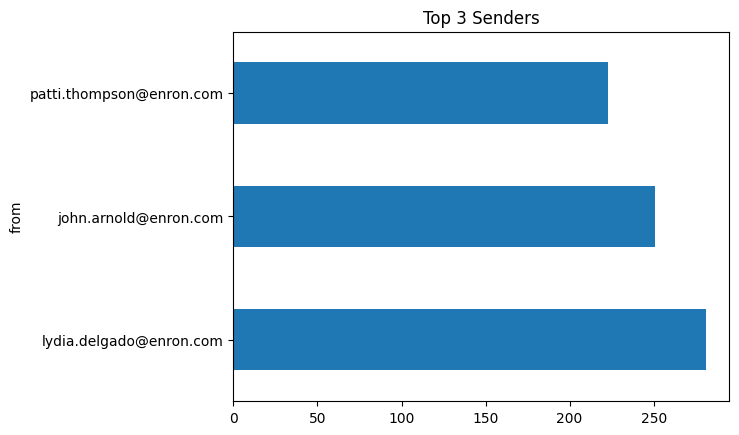

In [324]:
# Top 3 Email Senders Plot
df_filtered['from'].value_counts().nlargest(3).plot(kind='barh', title='Top 3 Senders')
plt.savefig('top senders.png')
plt.show()
# observation:
# top 3 senders patti.thompson@enron.com, john.arnold@enron.com, lydia.delgado@enron.com

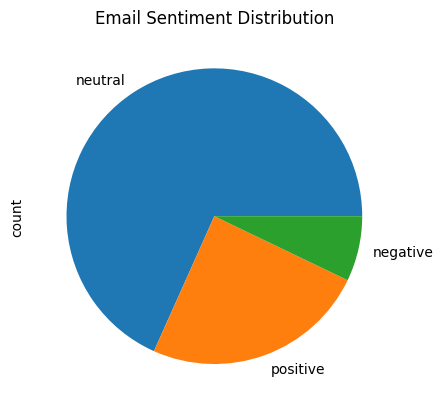

In [325]:
# Email Sentiment Distribution
df_filtered['Sentiments'].value_counts().plot(kind='pie', title='Email Sentiment Distribution')
plt.savefig('email sentiment.png')
plt.show()
# observation:
# Highest Sentiment: neutral
# Least Sentiment: negative

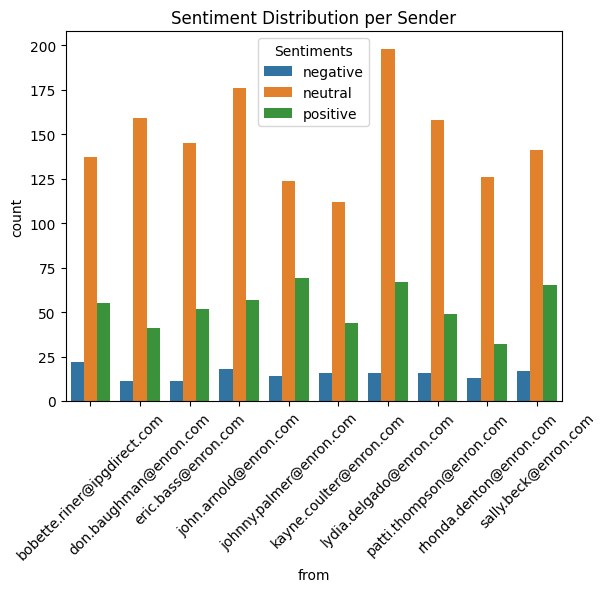

In [326]:
# Group by sender and sentiment
sentiment_counts = df_filtered.groupby(['from', 'Sentiments']).size().reset_index(name='count')

# Sentiment Distribution per Sender Plot
sns.barplot(data=sentiment_counts, x='from', y='count', hue='Sentiments')
plt.xticks(rotation=45)
plt.title('Sentiment Distribution per Sender')
plt.savefig('Sentiment Distribution per Sender.png')
plt.show()
# observation:
# Most nuetral email sender: lydia.delgado@enron.com
# Most positive email sender: johnny.palmer@enron.com
# Most negative email sender: bobette.riner@ipgdirect.com

**Employee Sentiment Scoring**

In [327]:
# Assigning sentiment score
df_filtered['sentiment_score'] = df_filtered['Sentiments'].map({'positive': 1,'neutral': 0,'negative': -1})

In [328]:
  # employee monthly sentiment score
monthly_scores = (
    df_filtered
    .groupby(['from', 'year_month'])['sentiment_score']
    .sum()
    .reset_index()
    .rename(columns={'from': 'employee', 'sentiment_score': 'monthly_sentiment_score'})
)


In [329]:
# Top 3 positive employees per month
top3_positive = (monthly_scores.sort_values(['year_month', 'monthly_sentiment_score'], ascending=[True, False]).groupby('year_month').head(3).sort_values(['year_month', 'employee']))

In [330]:
# top 3 negative employees per month
top3_negative = (monthly_scores.sort_values(['year_month', 'monthly_sentiment_score'], ascending=[True, True]).groupby('year_month').head(3).sort_values(['year_month', 'employee']))


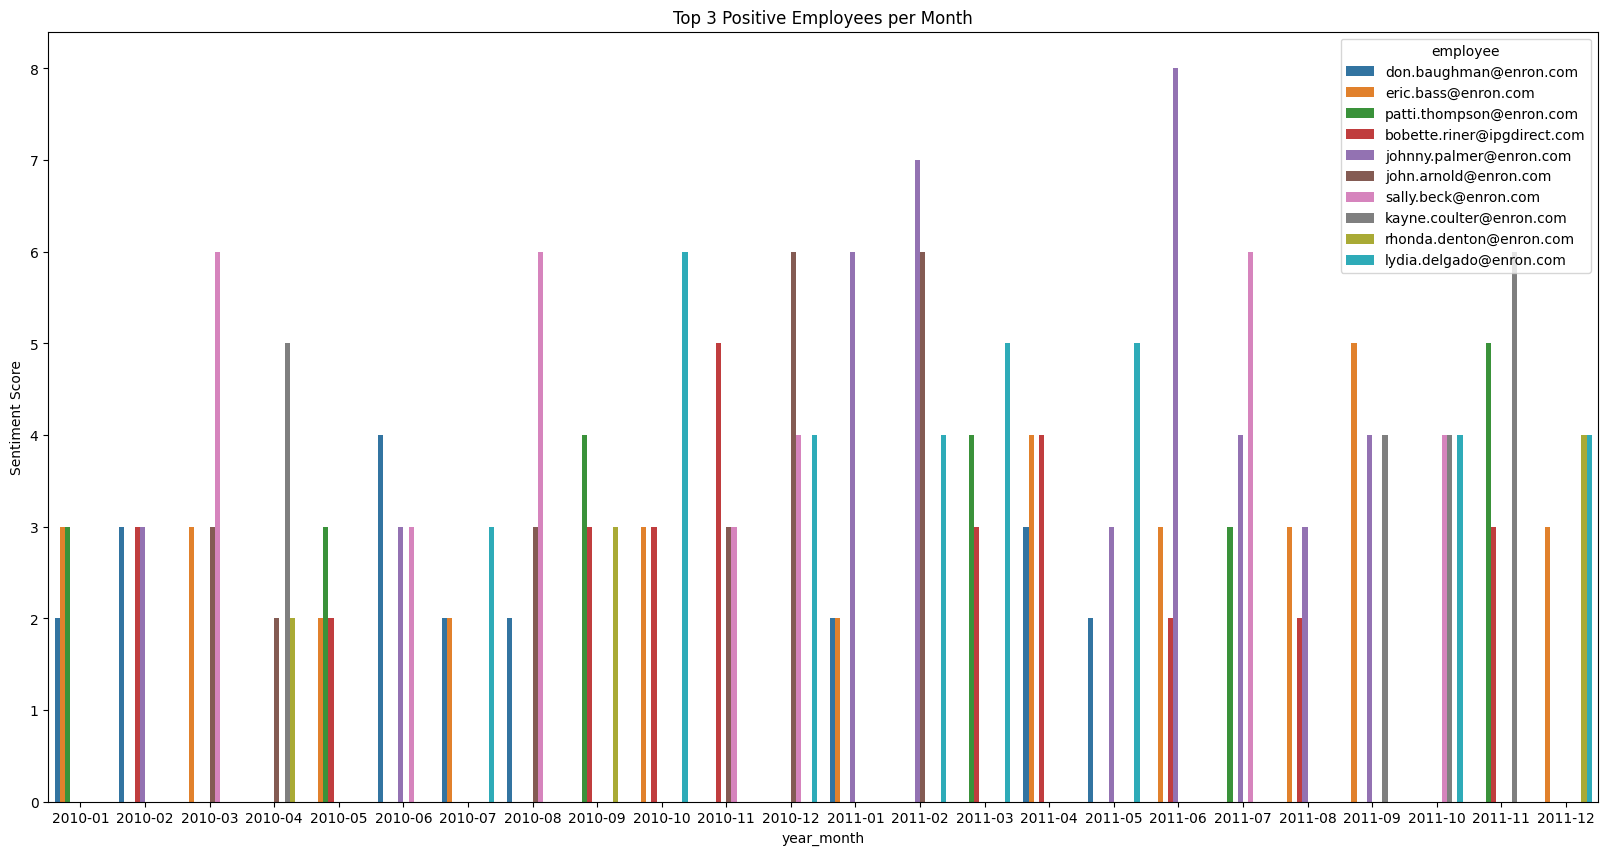

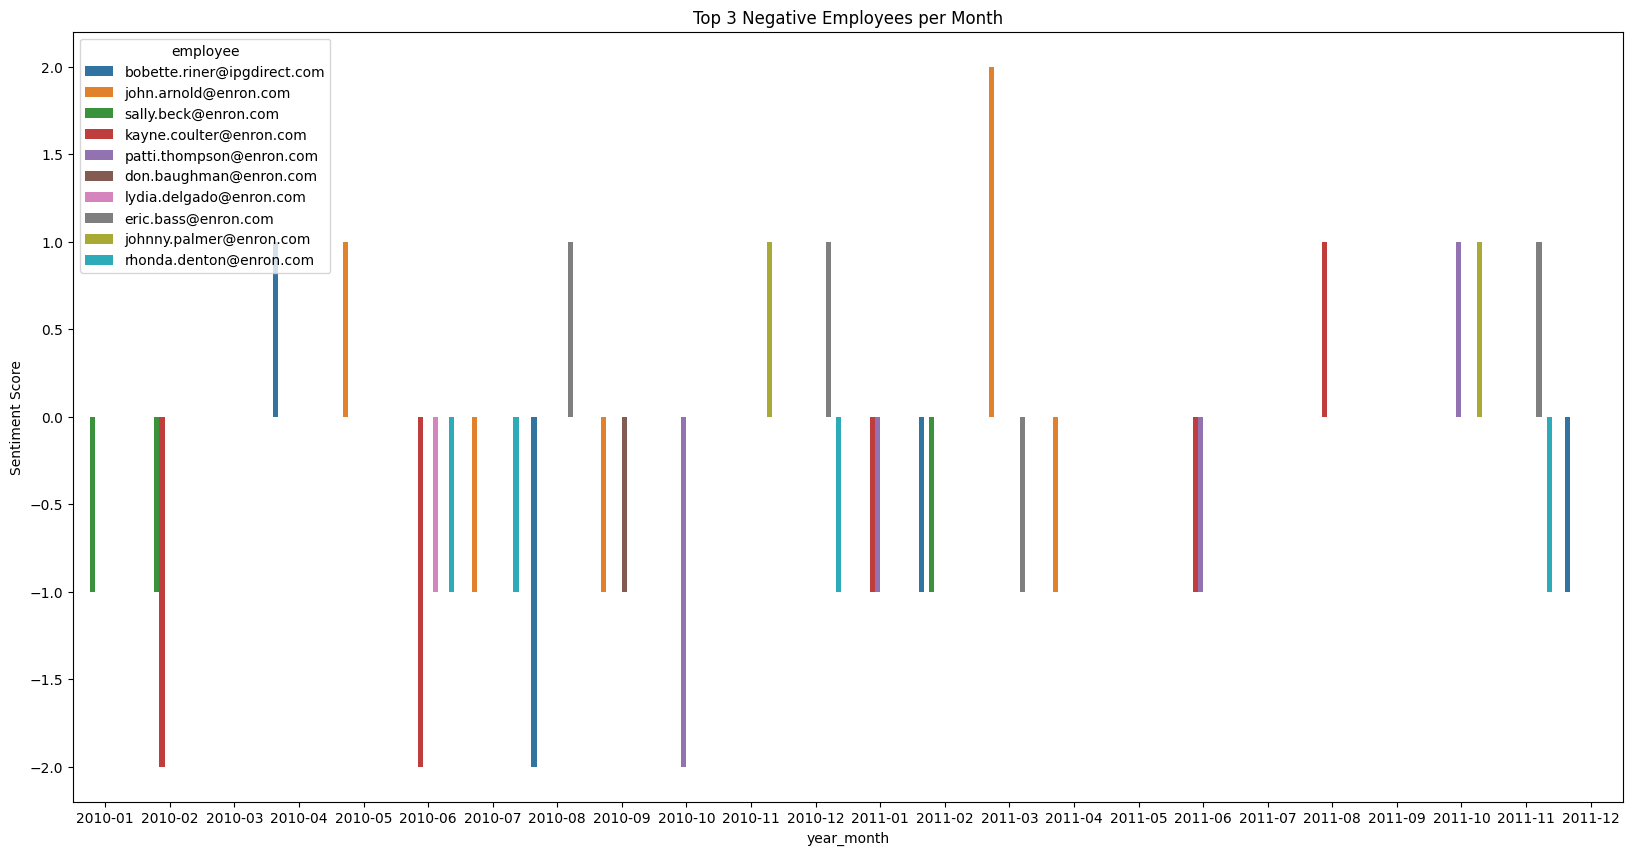

In [331]:
# Plot Top Positive
plt.figure(figsize=(20,10))
sns.barplot(data=top3_positive, x='year_month', y='monthly_sentiment_score', hue='employee')
plt.title('Top 3 Positive Employees per Month')
plt.ylabel('Sentiment Score')
plt.savefig('top pos.png')
plt.show()

# Plot Top Negative
plt.figure(figsize=(20,10))
sns.barplot(data=top3_negative, x='year_month', y='monthly_sentiment_score', hue='employee')
plt.title('Top 3 Negative Employees per Month')
plt.ylabel('Sentiment Score')
plt.savefig('top neg.png')
plt.show()

**Flight Risk Identification**

In [332]:
flight_risk_employees = [] # empty list to add employees at risk

# Group by from
for emp, group in df_filtered[df_filtered['Sentiments'] == 'negative'].groupby('from'):
    dates = pd.to_datetime(group['date']).sort_values().reset_index(drop=True)  # sort by date
    for i in range(len(dates)):
        # Count how many dates fall within 30 days ahead
        count = ((dates - dates[i]) <= timedelta(days=30)) & ((dates - dates[i]) >= timedelta(0))
        if count.sum() >= 4:
            flight_risk_employees.append(emp)
            break  # No need to check further

In [333]:
# print employees at risk
if flight_risk_employees:
    print("🚨 Flight Risk Employees:")
    for emp in flight_risk_employees:
        print(emp)
else:
    print("✅ No employees at risk.")

# Output:
#bobette.riner@ipgdirect.com
#rhonda.denton@enron.com
#sally.beck@enron.com


🚨 Flight Risk Employees:
bobette.riner@ipgdirect.com
rhonda.denton@enron.com
sally.beck@enron.com


**Predict Sentiment Score**

In [334]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Creating New Features

In [335]:
# Message length and word_count features
df_filtered['message_length'] = df_filtered['body'].apply(lambda x: len(str(x)))
df_filtered['word_count'] = df_filtered['body'].apply(lambda x: len(str(x).split()))

In [336]:
# Monthly message per user
monthly_message_freq = df_filtered.groupby(['from', 'year_month']).size().reset_index(name='message_count')

In [337]:
# Merge monthly_message_freq back to main df
df_filtered = df_filtered.merge(monthly_message_freq, on=['from', 'year_month'], how='left')

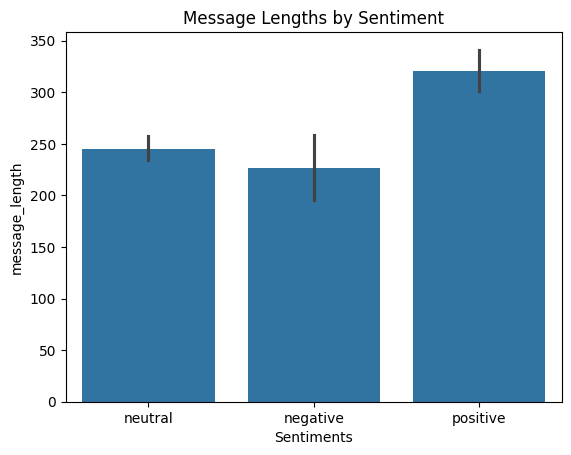

In [338]:
sns.barplot(x=df_filtered['Sentiments'], y=df_filtered['message_length'])
plt.title('Message Lengths by Sentiment')
plt.show()
# Observation: positive sentiment has highest message length compared to other, can help in predicting sentiment score

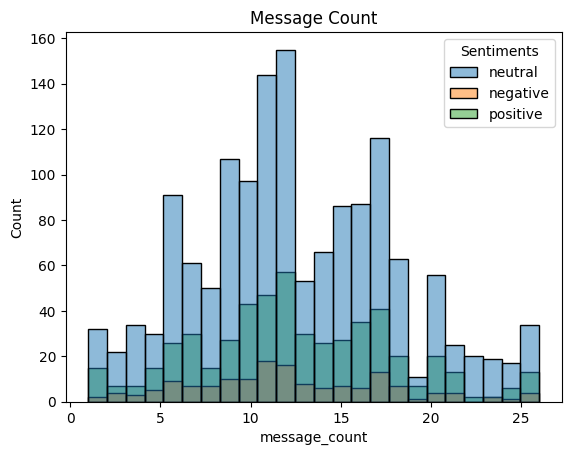

In [339]:
sns.histplot(data=df_filtered,x=df_filtered['message_count'],hue='Sentiments')
plt.title('Message Count')
plt.show()
# Observation: Neutral sentiment has highest message count, this dominant trend can help in predicting sentiment score.

Text Normalization and TF-IDF Encoding

In [340]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def clean_and_lemmatize(text):
    tokens = word_tokenize(str(text).lower())  # Lowercase and tokenize
    cleaned = [
        lemmatizer.lemmatize(token) # lemmatize tokens
        for token in tokens
        if token.isalnum() and token not in stop_words  # alphanumeric and stopwords check

    ]
    return ' '.join(cleaned)

In [341]:
df_filtered['body_cleaned'] = df_filtered['body'].apply(clean_and_lemmatize) # apply function to clean text

In [342]:
df_filtered['body_cleaned'] = df_filtered['body_cleaned'].str.lower() # lowercase body of email

In [343]:
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df_filtered['body_cleaned']) # apply Tfidf to body of email

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

Outliers and skewness

<Axes: >

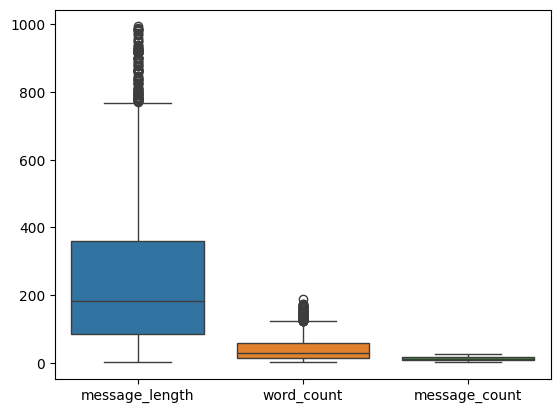

In [344]:
sns.boxplot(data=df_filtered[['message_length','word_count','message_count']])
# message_length and word_count has outliers

In [345]:
 # check skewness of message_length,word_count,message_count
df_filtered[['message_length','word_count','message_count']].skew()
# message_length and word_count are Right-skewed

,0
message_length,1.235139
word_count,1.297284
message_count,0.251149


In [346]:
# transform to reduce skewness
df_filtered['message_length'] = np.log1p(df_filtered['message_length'])
df_filtered['word_count'] = np.log1p(df_filtered['word_count'])

Selected Features

In [347]:
# selected features
x=df_filtered[['message_length','word_count','message_count']]

In [348]:
# Join TF-IDF with selected features
df_final = pd.concat([x.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

In [349]:
# Target variable
y=df_filtered['sentiment_score']

Feature Scaling

In [350]:
robust_scaler = RobustScaler() # Applied RobustScaler to handle skewed and outlier message_length and word_count
standard_scaler = StandardScaler() # Used StandardScaler for mild skewed message_count

In [351]:
# Apply RobustScaler to message_length and word_count
df_final[['message_length', 'word_count']] = robust_scaler.fit_transform(df_final[['message_length', 'word_count']])


In [352]:
# Apply StandardScaler to message_count
df_final[['message_count']] = standard_scaler.fit_transform(df_final[['message_count']])

Train model

In [353]:
model=LinearRegression()

In [354]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df_final,y, test_size=0.2, random_state=42)

In [355]:
# Train Model
model.fit(X_train, y_train)


LinearRegression()

Predict and Evaluate

In [356]:
# Predict
predictions = model.predict(X_test)

In [357]:
# Evaluate using MAE due to Outliers
print("MAE:", mean_absolute_error(y_test, predictions))
# observation: On average, model’s prediction error is around 0.316 sentiment points.

print("R² Score:", r2_score(y_test, predictions))
# observation: ~29.7% variance explained by model

MAE: 0.316412801501183
R² Score: 0.29661955524922357


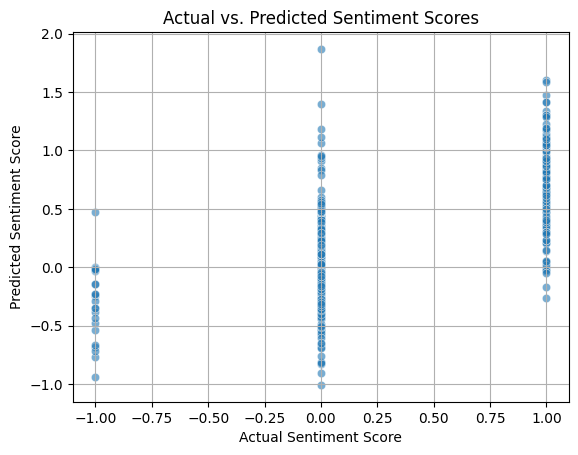

In [358]:
# Actual vs Predicted Sentiment Scores Plot
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.grid(True)
plt.show()
# observation:
# The model struggles most with negative sentiments (predictions are farther from -1).
# It performs better for positive sentiments, predicting scores closer to +1.
# Neutral predictions are somewhat accurate.